# DataCollatorForLanguageModeling_3

## 1. Import 및 라이브러리 설치

In [1]:
import gc
import torch
import sys

gc.collect()
torch.cuda.empty_cache()

In [2]:
!pip install rouge_score
!pip install datasets==1.0.2
!pip install transformers==4.24.0
!pip install transformer-utils
!pip install packaging
!pip install wandb

In [3]:
# mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-11-23 07:24:42--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-11-23 07:24:42--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd24f69c1fd627631e07687cd1b.dl.dropboxusercontent.com/cd/0/get/BxS4xO_9hI-oURNedsG7t5ycqisNzT_8sNhkJkiBF6S49XHAHIGr4zcSYI89BuJVg0GoRXr-6_WyScGgQvJDbnalJK_nQ_jb_61F2KB2WdizSlgdke4pXgwGLQf3dHKn7zPOuGa7OZqzgv55FWHuzac0aBRxVFLa9u2mY5mzukbhCz1nfv1Avc--x9zTc0pm0oo/file?dl=1# [following]
--2022-11-23 07:24:43--  https://ucd24f69c1fd627631e07687cd1b.dl.dropboxusercontent.com/cd/0/get/BxS4xO_9hI-o

In [4]:
# 필요한 라이브러리 불러오기
import datasets
import transformers
import pandas as pd
from datasets import Dataset



import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    LineByLineTextDataset,
    EarlyStoppingCallback

)

from transformers import RobertaTokenizerFast
from transformers import EncoderDecoderModel
from dataclasses import dataclass, field
from typing import Optional
from datasets import load_dataset, load_from_disk
from tqdm import tqdm
from tabulate import tabulate
from konlpy.tag import Mecab

## 2. 모델 및 데이터 불러오기

### 1) 모델 불러오기

In [5]:
model_checkpoints = "gogamza/kobart-base-v2" #/MLM_pretrain_3ep_221121/checkpoint-33000"#"gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [6]:
total_count = 0
for i in model.parameters():
    total_count += 1
count= 0
for i in model.parameters():
    count += 1
    i.requires_grad = False
    if count == total_count-3:
        break

### 2) 데이터 불러오기 및 확인

In [7]:
train_textfile_path = "data/train_text.csv"
val_textfile_path = "data/val_text.csv"

with open(train_textfile_path, encoding="utf-8") as f:
            train_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]     

with open(val_textfile_path, encoding="utf-8") as f:
            val_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]


In [8]:
del train_textlines[0]
del val_textlines[0]

In [9]:
train_df = pd.DataFrame(zip(train_textlines), columns=['Text'])
val_df = pd.DataFrame(zip(val_textlines), columns=['Text'])

In [10]:
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

In [11]:
train_df.head()

,Text
0,그럼 날짜는 가격 큰 변동 없으면 6 28-7 13로 확정할까 우리 비행포함 15일...
1,kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마스크말고 부직포 마...
2,아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 그냥그런것같애 그러...
3,칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남 아 그 왕칫솔 또 사려나 싶...
4,잠도안오네 얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보 빼이보릿 되버렸네...


## 3. 데이터 EDA

In [12]:
mecab = Mecab()

def sentence_len_total(data):
    text_split_text = []
    # 반복문으로 Mecab 적용
    for text_sen in tqdm(data['Text'].iloc[range(0, len(data))]):
        text_split_text.append(mecab.morphs(text_sen))
    
    temp = pd.DataFrame(zip(text_split_text), columns=['Text'])
    
    # Mecab 적용 후 길이 출력
    text_len = temp.Text.map(len)
    
    # text_len 사분위수 구하기    
    text_Q1 = text_len.quantile(.25)
    text_Q3 = text_len.quantile(.75)
    text_IQR = text_Q3 - text_Q1
    text_Q2 = text_len.quantile(.5)
    text_Q4 = text_len.quantile(1)
    text_threshold_len_left = text_Q1 - (1.5 * text_IQR)
    text_threshold_len_right = text_Q3 + (1.5 * text_IQR)

    
    print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
    print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
    print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
    print('텍스트의 왼쪽 울타리 범위 : {}'. format(text_threshold_len_left),
         '텍스트의 오른쪽 울타리 범위 : {}'. format(text_threshold_len_right))
    print('text_Q1 = {}'.format(text_Q1), 'headlines_Q1 = {}'.format(text_Q1))
    print('text_Q3 = {}'.format(text_Q3), 'headlines_Q3 = {}'.format(text_Q3))
    print('text_IQR = {}'.format(text_IQR), 'headlines_IQR = {}'.format(text_IQR))
    print('text_Q2 = {}'.format(text_Q2), 'headlines_Q2 = {}'.format(text_Q2))
    print('text_Q4 = {}'.format(text_Q4), 'headlines_Q4 = {}'.format(text_Q4))

    
    plt.subplot(1,1,1)
    plt.boxplot(text_len)
    plt.title('text')
    plt.show()

    plt.title('text')
    plt.hist(text_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    return data


100%|██████████| 279992/279992 [01:11<00:00, 3908.51it/s]


텍스트의 최소 길이 : 7
텍스트의 최대 길이 : 923
텍스트의 평균 길이 : 55.99256050172862
텍스트의 왼쪽 울타리 범위 : -3.0 텍스트의 오른쪽 울타리 범위 : 109.0
text_Q1 = 39.0 headlines_Q1 = 39.0
text_Q3 = 67.0 headlines_Q3 = 67.0
text_IQR = 28.0 headlines_IQR = 28.0
text_Q2 = 51.0 headlines_Q2 = 51.0
text_Q4 = 923.0 headlines_Q4 = 923.0


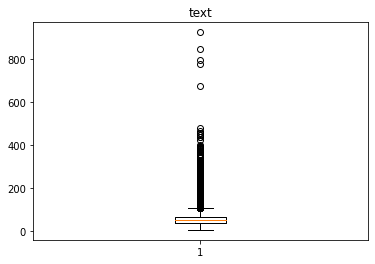

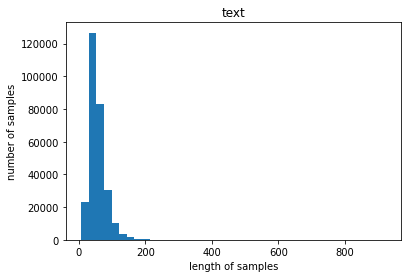

,Text
0,그럼 날짜는 가격 큰 변동 없으면 6 28-7 13로 확정할까 우리 비행포함 15일...
1,kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마스크말고 부직포 마...
2,아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 그냥그런것같애 그러...
3,칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남 아 그 왕칫솔 또 사려나 싶...
4,잠도안오네 얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보 빼이보릿 되버렸네...
...,...
279987,도착하샸나염 자리잡고 알려주이소 아아 나 다이소좀 구경하느랔 웅 이제 할리스 지나쳐...
279988,시간잘봐라 겁나 여러가지다 예약내역 올려바바 그러게 호텔은 언제해여 표사고 오늘밤
279989,언제 도착요정이십니까 15분뒤 도착이룝 옥희여 이제 나오묜 될듯 나나홨오 나와 오 ...
279990,근데 현인가요제 가면 최소20시간은 줄서서 기다려야하는거아님 그정도는아니고 한 열두...


In [13]:
sentence_len_total(train_df)

100%|██████████| 35004/35004 [00:09<00:00, 3814.26it/s]


텍스트의 최소 길이 : 9
텍스트의 최대 길이 : 547
텍스트의 평균 길이 : 56.268940692492286
텍스트의 왼쪽 울타리 범위 : -3.0 텍스트의 오른쪽 울타리 범위 : 109.0
text_Q1 = 39.0 headlines_Q1 = 39.0
text_Q3 = 67.0 headlines_Q3 = 67.0
text_IQR = 28.0 headlines_IQR = 28.0
text_Q2 = 51.0 headlines_Q2 = 51.0
text_Q4 = 547.0 headlines_Q4 = 547.0


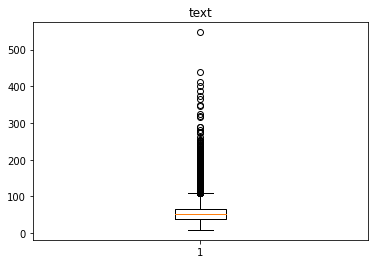

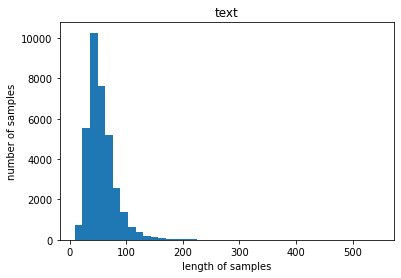

,Text
0,웅 영업팀과장님이 보내줬는데 팀장님이 해줄지 모르겠다 저번에 부산갈때도 숙소로 엄청...
1,너는 잘가라 회사 선택 잘해 알겠어 많이 힘들구나 나도 이제 이력서쓰고 영어도 해야...
2,느낌상 대통령까지는 아니고 오시면 여사님정도오시지않을까 그러면서 샘 여기있었구낭 종...
3,숨만수이 도 숨만쉬어도 100 이내 한달안에 일 무조건 해야대 아 딱한달 그냥 아무...
4,목요일은 외근이구 금요일은 출장 금요일이 당진이양 아닝아닝 10일이 당진이야 그럼 ...
...,...
34999,방금 샐러드 정기배송 주문한 거 먹었눈데 왜 먹어도 배고푸야 샐러드 정기배송도 시켜...
35000,닭갈비 맛있었다 맛나맛나 그티웅 아깐 먹기 싫다더니 역시 너의 선택 최고엿어 요즘 ...
35001,나 핫바 먹어야지 먹을래 아니 난 안 무거 그럼 나만 먹는다잉 핫바 찍어먹을 소스 ...
35002,아 본죽에 신메뉴 나온 거 알아 오 신메뉴 나온 걸 왜 못봤지 언니는 오늘 갔었는데...


In [14]:
sentence_len_total(val_df)

In [15]:
print(train_df.head())
print(val_df.head())

                                                Text
0  그럼 날짜는 가격 큰 변동 없으면 6 28-7 13로 확정할까 우리 비행포함 15일...
1  kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마스크말고 부직포 마...
2  아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 그냥그런것같애 그러...
3  칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남 아 그 왕칫솔 또 사려나 싶...
4  잠도안오네 얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보 빼이보릿 되버렸네...
                                                Text
0  웅 영업팀과장님이 보내줬는데 팀장님이 해줄지 모르겠다 저번에 부산갈때도 숙소로 엄청...
1  너는 잘가라 회사 선택 잘해 알겠어 많이 힘들구나 나도 이제 이력서쓰고 영어도 해야...
2  느낌상 대통령까지는 아니고 오시면 여사님정도오시지않을까 그러면서 샘 여기있었구낭 종...
3  숨만수이 도 숨만쉬어도 100 이내 한달안에 일 무조건 해야대 아 딱한달 그냥 아무...
4  목요일은 외근이구 금요일은 출장 금요일이 당진이양 아닝아닝 10일이 당진이야 그럼 ...


## 4. 데이터 토큰화

### 1) dataset으로 변환

In [16]:
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)

### 2) EDA 바탕으로 길이 지정

In [17]:
max_input = 70# 5e128
max_target = 70 # 5e 128
batch_size = 4
ignore_index = -100

### 3) 토큰화 함수 구현 및 토큰화

In [18]:
def add_ignored_data(inputs, max_len, ignore_index):
    if len(inputs) < max_len:
        pad = [ignore_index] *(max_len - len(inputs)) # ignore_index즉 -100으로 패딩을 만들 것인데 max_len - lne(inpu)
        inputs = np.concatenate([inputs, pad])
    else:
        inputs = inputs[:max_len]

    return inputs

In [19]:
def preprocess_data(data_to_process):
    label_id= []
    label_ids = []

    inputs = [dialogue for dialogue in data_to_process['Text']]
    model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)

    for i in range(len(data_to_process['Text'])):
        label_id.append(tokenizer.encode(data_to_process['Text'][i]))  
    for i in range(len(data_to_process['Text'])):
        label_id[i].append(tokenizer.eos_token_id)
        label_ids.append(add_ignored_data(label_id[i], max_target, ignore_index))

    model_inputs['labels'] = label_ids

    return model_inputs

In [20]:
train_tokenize_data = train_data.map(preprocess_data, batched = True, remove_columns=['Text'])
val_tokenize_data = val_data.map(preprocess_data, batched = True, remove_columns=['Text'])

  0%|          | 0/280 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

## 5. 학습을 진행하기 위한 준비

### 1) config 지정

In [21]:

model.config.decoder_start_token_id = tokenizer.bos_token_id                                             
model.config.eos_token_id = tokenizer.eos_token_id

# sensible parameters for beam search
# set decoding params                               
model.config.max_length = 70#128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 2
model.config.length_penalty = 2.0
model.config.num_beams = 2


### 2) rounge 함수 구현

In [22]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     print("labels_ids",labels_ids)
#     print("labels_ids[labels_ids == -100]",labels_ids[labels_ids == -100])
#     print("tokenizer.pad_token_id",tokenizer.pad_token_id)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
    rouge_output2 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    rouge_outputL = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid
    

    return {
        "rouge1_precision": round(rouge_output.precision, 4),
        "rouge1_recall": round(rouge_output.recall, 4),
        "rouge1_fmeasure": round(rouge_output.fmeasure, 4),
        
        "rouge2_precision": round(rouge_output2.precision, 4),
        "rouge2_recall": round(rouge_output2.recall, 4),
        "rouge2_fmeasure": round(rouge_output2.fmeasure, 4), 
        
        "rougeL_precision": round(rouge_outputL.precision, 4),
        "rougeL_recall": round(rouge_outputL.recall, 4),
        "rougeL_fmeasure": round(rouge_outputL.fmeasure, 4),
    }

### 3) arguments 지정

In [23]:
training_args = Seq2SeqTrainingArguments(
    output_dir="MLM_pretrain_basev2_freezing",
    num_train_epochs=1,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,  # demo
    per_device_eval_batch_size=16,
    learning_rate=3e-05,
    warmup_steps=500,
    weight_decay=0.1,
    label_smoothing_factor=0.1,
    predict_with_generate=True, # 생성기능을 사용하고 싶다고 지정한다.
    logging_dir="logs2",
    logging_steps=500,
    save_total_limit=3,
    #evaluation_strategy = "steps",# step별로 2버 loss가 오르는거 아니면 계속 반복하는듯
   # load_best_model_at_end = True,

)

### 4) data_collator

In [24]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

### 5) train

In [25]:
trainer = Seq2SeqTrainer(
    model, 
    training_args,
    train_dataset=train_tokenize_data,
    eval_dataset=val_tokenize_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 279992
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 17500
  Number of trainable parameters = 2304
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: jx7789. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,7.579400
1000,7.514900
1500,7.512100
2000,7.499600
2500,7.469900
3000,7.455800
3500,7.401900
4000,7.451600
4500,7.418500
5000,7.415200


Saving model checkpoint to MLM_pretrain_basev2_freezing/checkpoint-500
Configuration saved in MLM_pretrain_basev2_freezing/checkpoint-500/config.json
Model weights saved in MLM_pretrain_basev2_freezing/checkpoint-500/pytorch_model.bin
tokenizer config file saved in MLM_pretrain_basev2_freezing/checkpoint-500/tokenizer_config.json
Special tokens file saved in MLM_pretrain_basev2_freezing/checkpoint-500/special_tokens_map.json
Saving model checkpoint to MLM_pretrain_basev2_freezing/checkpoint-1000
Configuration saved in MLM_pretrain_basev2_freezing/checkpoint-1000/config.json
Model weights saved in MLM_pretrain_basev2_freezing/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in MLM_pretrain_basev2_freezing/checkpoint-1000/tokenizer_config.json
Special tokens file saved in MLM_pretrain_basev2_freezing/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to MLM_pretrain_basev2_freezing/checkpoint-1500
Configuration saved in MLM_pretrain_basev2_freezing/checkpoint-15

TrainOutput(global_step=17500, training_loss=7.366375948660714, metrics={'train_runtime': 3030.2069, 'train_samples_per_second': 92.4, 'train_steps_per_second': 5.775, 'total_flos': 1.16704034463744e+16, 'train_loss': 7.366375948660714, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 35004
  Batch size = 16


## 6. 학습 결과 확인

In [ ]:
with open(val_textfile_path, encoding="utf-8") as f:
            val_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]
        
val_df = pd.DataFrame(zip(val_textlines), columns=['Text'])
val_df.reset_index(inplace=True, drop=True)

In [ ]:
def generate_summary(test_samples, model):
    inputs = tokenizer(
        test_samples["Text"],
        padding="max_length",
        truncation=True,
        max_length=max_target,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, num_beams=2,no_repeat_ngram_size=2, max_length=128,
                            suppress_tokens= [234,23782,14338,240,199,198,161,116, 14338, 239], 
                             attention_mask=attention_mask, top_p=0.92)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str


model_before_tuning = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)# 여기에 기본 kobart가져오기?
import random
from random import randrange
ck_num = len(val_data)
test_samples = val_data.select(range(0, ck_num, 1000))# 0, len(test_data), 200

summaries_before_tuning = generate_summary(test_samples, model_before_tuning)[1]
summaries_after_tuning = generate_summary(test_samples, model)[1] # 여기에 체크포인트 가져오기 
# 연구해봐야한다.

In [ ]:
for i in range(len(summaries_after_tuning)):
    print('idx_{} '.format(i))
    print("Summary before \n", summaries_before_tuning[i])
    print()
    print("Summary after \n", summaries_after_tuning[i])
    print()
    print("Target summary \n", test_samples["Summary"][i])
    print()
    print('Text', test_samples["Text"][i])
    print('-'*100)
    print()  